<a href="https://colab.research.google.com/github/trtrgfh/7sGNwtDKjIZW3Zfi/blob/main/Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score, make_scorer
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Prepare Data

In [2]:
df = pd.read_csv("/content/term-deposit-marketing-2020.csv")
df.head(), df.shape

(   age           job  marital  education default  balance housing loan  \
 0   58    management  married   tertiary      no     2143     yes   no   
 1   44    technician   single  secondary      no       29     yes   no   
 2   33  entrepreneur  married  secondary      no        2     yes  yes   
 3   47   blue-collar  married    unknown      no     1506     yes   no   
 4   33       unknown   single    unknown      no        1      no   no   
 
    contact  day month  duration  campaign   y  
 0  unknown    5   may       261         1  no  
 1  unknown    5   may       151         1  no  
 2  unknown    5   may        76         1  no  
 3  unknown    5   may        92         1  no  
 4  unknown    5   may       198         1  no  ,
 (40000, 14))

In [3]:
df = df.drop(["job", "contact", "day", "month"], axis=1)
df.head(), df.shape

(   age  marital  education default  balance housing loan  duration  campaign  \
 0   58  married   tertiary      no     2143     yes   no       261         1   
 1   44   single  secondary      no       29     yes   no       151         1   
 2   33  married  secondary      no        2     yes  yes        76         1   
 3   47  married    unknown      no     1506     yes   no        92         1   
 4   33   single    unknown      no        1      no   no       198         1   
 
     y  
 0  no  
 1  no  
 2  no  
 3  no  
 4  no  ,
 (40000, 10))

## One-Hot Encoding and Binary Encoding


In [4]:
# Get the unique items used in one-hot encoding columns
marital = df["marital"].unique()
education = df["education"].unique()

In [5]:
encoder = OneHotEncoder()

# Perform one-hot encoding on "marital" and "education" columns
encoder_marital = pd.DataFrame(encoder.fit_transform(df[["marital"]]).toarray(), columns = marital)
encoder_edu = pd.DataFrame(encoder.fit_transform(df[["education"]]).toarray(), columns = education)

# Merge one-hot encoded columns back with original DataFrame
df = df.join(encoder_marital)
df = df.join(encoder_edu)
df.rename(columns={'unknown':'unknown_edu'}, inplace=True)
df = df.drop(["marital", "education"], axis=1)

In [6]:
print(df.shape)
df.head()

(40000, 15)


,age,default,balance,housing,loan,duration,campaign,y,married,single,divorced,tertiary,secondary,unknown_edu,primary
0,58,no,2143,yes,no,261,1,no,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,44,no,29,yes,no,151,1,no,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,33,no,2,yes,yes,76,1,no,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,47,no,1506,yes,no,92,1,no,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,33,no,1,no,no,198,1,no,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [7]:
df = df.replace(to_replace=['no', 'yes'], value=[0, 1])
df.head()

,age,default,balance,housing,loan,duration,campaign,y,married,single,divorced,tertiary,secondary,unknown_edu,primary
0,58,0,2143,1,0,261,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,44,0,29,1,0,151,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,33,0,2,1,1,76,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,47,0,1506,1,0,92,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,33,0,1,0,0,198,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Finding Outliers

In [8]:
df[["age", "balance", "duration"]].describe()

,age,balance,duration
count,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,254.824300
std,9.641776,2903.769716,259.366498
min,19.000000,-8019.000000,0.000000
25%,33.000000,54.000000,100.000000
50%,39.000000,407.000000,175.000000
75%,48.000000,1319.000000,313.000000
max,95.000000,102127.000000,4918.000000


In [9]:
threshold = 3
z_scores = stats.zscore(df[["age", "balance", "duration"]])
outlier_indices = (z_scores > threshold).any(axis=1)
outliers = df[outlier_indices]
print(outliers.shape)
outliers.head()

(1604, 15)


,age,default,balance,housing,loan,duration,campaign,y,married,single,divorced,tertiary,secondary,unknown_edu,primary
34,51,0,10635,1,0,336,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
37,53,0,-3,0,0,1666,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
43,54,0,529,1,0,1492,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
59,46,0,179,1,0,1778,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
69,35,0,12223,1,1,177,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [10]:
df = df[~outlier_indices]

## Feature Scaling

In [11]:
scaler = StandardScaler()
df[["age", "balance", "duration"]] = scaler.fit_transform(df[["age", "balance", "duration"]])

# Training

In [12]:
# Get feature and target dataset 
y = df[["y"]]
X = df.drop(["y"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (30716, 14)
X_test shape: (7680, 14)
y_train shape: (30716, 1)
y_test shape: (7680, 1)


In [13]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 5, 10]
}

In [14]:
# Create an instance of the XGBoost Classifier
xgb_model = xgb.XGBClassifier()

# Create a KFold object with the desired number of folds (k)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score)

# Perform grid search using GridSearchCV with k-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scorer, cv=kfold)

# Fit the grid search object to your training data
grid_search.fit(X, y)

# Access the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

In [15]:
# Save trained best model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [16]:
# Load best model
load_model = pickle.load(open("xgboost_model.pkl", "rb"))
pred_y = load_model.predict(X_train)
pred_y_test = load_model.predict(X_test)

In [17]:
# Calculate metrics for training set
print("Training")
print(f"Train_Precision: {precision_score(y_train, pred_y)}")
print(f"Train_Recall: {recall_score(y_train, pred_y)}")
print(f"Train_F1score: {f1_score(y_train, pred_y)}")
print(f"Train_Accuracy: {accuracy_score(y_train, pred_y)}")

# Calculate metrics for testing set
print("Testing")
print(f"Test_Precision: {precision_score(y_test, pred_y_test)}")
print(f"Test_Recall: {recall_score(y_test, pred_y_test)}")
print(f"Test_F1score: {f1_score(y_test, pred_y_test)}")
print(f"Test_Accuracy: {accuracy_score(y_test, pred_y_test)}")

Training
Train_Precision: 0.35818624467437615
Train_Recall: 0.6389793702497285
Train_F1score: 0.4590483619344774
Train_Accuracy: 0.9096887615574945
Testing
Test_Precision: 0.3333333333333333
Test_Recall: 0.6442953020134228
Test_F1score: 0.43935926773455375
Test_Accuracy: 0.904296875


In [18]:
y_train.value_counts(), y_test.value_counts()

(y
 0    28874
 1     1842
 dtype: int64,
 y
 0    7233
 1     447
 dtype: int64)

In [19]:
xgb.plot_tree(load_model, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig('figure1.png', bbox_inches='tight')
plt.show()

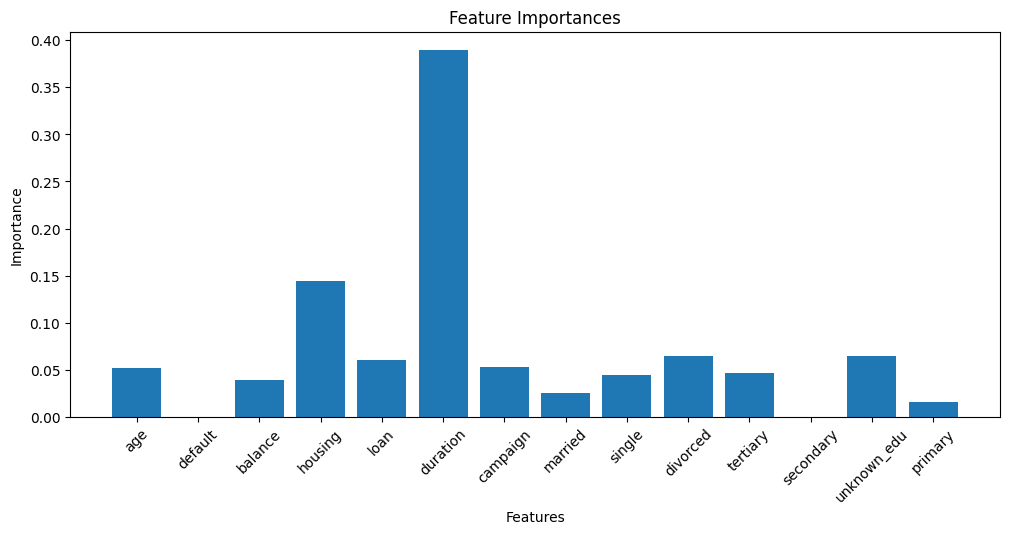

In [20]:
im_features = load_model.feature_importances_
plt.figure(figsize=(12,5))
plt.bar(range(len(im_features)), im_features)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(range(len(im_features)), X.columns.to_list(), rotation=45)
plt.savefig('figure2.png', bbox_inches='tight')
plt.show()